In [1]:
import regex as re

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [37]:
with open("./shakespeare.txt", "r", encoding="utf-8") as file:
    sample = file.read()

sample[:1000]

"1609\n\nTHE SONNETS\n\nby William Shakespeare\n\n\n\n                     1\n  From fairest creatures we desire increase,\n  That thereby beauty's rose might never die,\n  But as the riper should by time decease,\n  His tender heir might bear his memory:\n  But thou contracted to thine own bright eyes,\n  Feed'st thy light's flame with self-substantial fuel,\n  Making a famine where abundance lies,\n  Thy self thy foe, to thy sweet self too cruel:\n  Thou that art now the world's fresh ornament,\n  And only herald to the gaudy spring,\n  Within thine own bud buriest thy content,\n  And tender churl mak'st waste in niggarding:\n    Pity the world, or else this glutton be,\n    To eat the world's due, by the grave and thee.\n\n\n                     2\n  When forty winters shall besiege thy brow,\n  And dig deep trenches in thy beauty's field,\n  Thy youth's proud livery so gazed on now,\n  Will be a tattered weed of small worth held:  \n  Then being asked, where all thy beauty lies,\n 

---
    training data should look like:
    
    <center>       ->    <context>
    [0, ..., 1, 0] ->    [0, ..., 1, 0]
    [0, ..., 1, 0] ->    [0, ..., 0, 1]
    [0, ..., 1, 0] ->    [1, ..., 0, 0]
    ...            ->    ...
    
    where the center word (input) have a number of <context words>
    based on the size of the window hence:
        if window_size = 2; two context words from both sides (left & right).
    
    objective:
        based on the given input <center word> try to predict the output <context word>
        and when we reach to a good performance we hope that the neural network will
        try to extract hiddin features, which are going to be the meanings of input words
        in a numerical representation.
        
    steps:
        1. split input text into chunks (tokens)
        2. assign a token_id per token
        3. encode thoes tokens based on their ids (one-hot encoding)
        4. building the training data as intended above
        5. 
    
    NOTE: this is going to be the basic solution and from here i'll try to improve.
    
    


In [38]:
def tokenize(text):
    # simple tokenizer
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def encode(token_id, vocab_size):
    vector = [0] * vocab_size  # which is going to be the input vector size
    vector[token_id] = 1
    return np.array(vector)  # for training (later)

In [39]:
tokens = tokenize(sample)
tokens[:8]

['the',
 'sonnets',
 'by',
 'william',
 'shakespeare',
 'from',
 'fairest',
 'creatures']

In [40]:
token_to_id = {t: i for i, t in enumerate(set(tokens))}
id_to_token = {i: t for i, t in enumerate(set(tokens))}

In [41]:
vocab_size = len(set(tokens))
vocab_size

3199

In [42]:
def combine(*iterables):
    # to combine two iterables
    # into single iterable
    for iterable in iterables:
        yield from iterable

def build_train(tokens, token_to_id, vocab_size, window_size=2, verbose=False):
    center_vectors = []
    context_vectors = []
    for i, center in enumerate(tokens):
        # context words iterable on the right side
        r_ctx = range(i+1, min(i+window_size+1, len(tokens)))
        # context words iterable on the left side
        l_ctx = range(max(0, i-window_size), i)
        # combined context iterables from both sides
        c_ctx = combine(l_ctx, r_ctx)
    
        # get numerical representation (one-hot encoding)
        # for both: 1. center word 2. context word    
        cnt_w_id = token_to_id[center]  
        cnt_w_vector = encode(cnt_w_id, vocab_size)  # 1. center word
        for w_id in c_ctx:
            if verbose:
                # <center word>  ->  <ctx word>
                print(f"{center} -> {tokens[w_id]}")
                
            ctx_w_id = token_to_id[tokens[w_id]]
            ctx_w_vector = encode(ctx_w_id, vocab_size)  # 2. context word
            
            center_vectors.append(cnt_w_vector)
            context_vectors.append(ctx_w_vector)
    # store them as numpy.array for training        
    return np.array(center_vectors), np.array(context_vectors)

In [43]:
cnt, ctx = build_train(tokens, token_to_id, vocab_size)
print("center words shape: ", cnt.shape)
print("context words shape: ", ctx.shape)

center words shape:  (70682, 3199)
context words shape:  (70682, 3199)


    center words are duplicated:
    where the same center word has more than context words
    the size depends on the `window_size`
    
    center word (1) -> context word (1)
                    -> context word (2)
                    -> ...
                    -> context word (N)
    ...
    center word (M) -> context word (1)
                    -> context word (2)
                    -> ...
                    -> context word (N)


---

    Forward pass:
    -------------
    A1   = X @ W1
    A2   = A1 @ W2
    Z    = softmax(A2)
    Loss = cross_entropy(Z, y)
    
    
    How changing W2 impacted the loss?
    ----------------------------------
    >> dLoss(Z, y)/dW2 = dLoss/dZ * dZ/dA2 * dA2/dW2 
    >> dLoss(Z, y)/dW2 = (z - y)           * A1
    shape convention:
    - (z - y): (#samples, vocab_size)
    - A1:      (#samples, embedding_size)
    
    shape of target matrix to update (W2): (embedding_size, vocab_size)
    
    ==> A1.T @ (z-y)
    
    
    How changing W1 impacted the loss?
    ----------------------------------
    >> dLoss(Z, t)/dW1 = dLoss/dZ * dZ/dA2 * dA2/dA1 * dA1/dW1
    >> dLoss(Z, t)/dW1 = (z - y)           * W2      * X
    
    shape convention:
    - (z - y): (#samples, vocab_size)
    - W2:      (embedding_size, vocab_size)
    - X:       (#samples, vocab_size) 
    
    shape of target matrix to update (W1): (vocab_size, embedding_size)
    
    ==> x.T @ ( (z-y) @ W2.T )
    

In [54]:
np.random.seed(42)

class Model:
    def __init__(self, X, y, vocab_size, embedding_size):
        self.X = X
        self.y = y
        self.vocab_size = vocab_size
        self.w1 = np.random.randn(vocab_size, embedding_size)
        self.w2 = np.random.randn(embedding_size, vocab_size)
    
    def forward(self):
        self.a1 = self.X @ self.w1  # (vocab_size, embedding_size)
        self.a2 = self.a1 @ self.w2  # (tokens, vocab_size)
        self.z = self._softmax(self.a2)  # (tokens, vocab_size)
        return self.z
    
    def backward(self, alpha):
        self.forward()
        # derivatives
        dl = self.z - self.y
        dw2 = self.a1.T @ dl
        dw1 = self.X.T @ (dl @ self.w2.T)
        # shape validation
        assert(dw2.shape == self.w2.shape)
        assert(dw1.shape == self.w1.shape)
        # update weights
        self.w1 = self.w1 - (alpha * dw1)
        self.w2 = self.w2 - (alpha * dw2)
        # compute loss
        return self._cross_entropy(self.y, self.z)
    
    @staticmethod    
    def _softmax(a):
        # a = a - np.max(a)
        res = []
        for x in a:
            exp_ = np.exp(x)
            res.append(exp_ / exp_.sum())
        return res
    
    @staticmethod
    def _cross_entropy(actual, predicted, epsilon=1e-10):
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        return - np.sum(actual * np.log(predicted))

In [52]:
model = Model(cnt, ctx, vocab_size, 10)

 33%|███▎      | 1/3 [00:19<00:38, 19.23s/it]/var/folders/4c/_jt9rf9d39b1jdq0g0cvz7fw0000gn/T/ipykernel_48643/813560458.py:37: RuntimeWarning: overflow encountered in exp
  exp_ = np.exp(x)
/var/folders/4c/_jt9rf9d39b1jdq0g0cvz7fw0000gn/T/ipykernel_48643/813560458.py:38: RuntimeWarning: invalid value encountered in divide
  res.append(exp_ / exp_.sum())
100%|██████████| 3/3 [00:48<00:00, 16.16s/it]


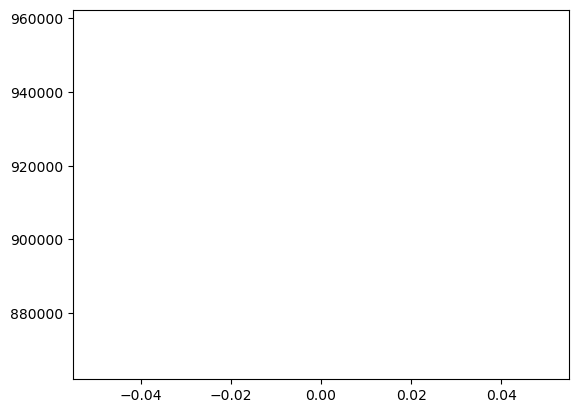

loss: nan
CPU times: user 39.6 s, sys: 31.1 s, total: 1min 10s
Wall time: 49.4 s


In [53]:
%%time
history = []
steps = []
for step in tqdm(range(3)):
    history.append(model.backward(alpha=0.05))
    steps.append(step)
    
plt.plot(steps, history)
plt.show()

print("loss:", history[-1])